**Project Name**: HR Analytics - Predicting Employee Turnover

**Author**: Ankur Dhamija

**Connect on Linkedin**: https://www.linkedin.com/in/ankurdhamija/

--------

# HR Analytics - Predicting Employee Turnover

-------

# 1. HR Analytics

With the evolution of Data Science, HR Analytics is having a significant impact on the HR policies of various organizations.

It is very important that companies recognize and understand what factors are associated with employee turnover. This will allow pro-active action and limit employee attrition at various firms.

Predictive analytics give managers the opportunity to take corrective steps to build and preserve their successful business.

------

# 2. Goal

*The goal is to understand what factors contribute most to employee turnover and create a model that can predict if a certain employee will leave the company or not.*

-----

# 3. Key Findings

- There is 16.60% Employee attrition at the firm
- Attrition rate is maximum for employees with `5 years of experience` at the firm
- Employees with `3 to 5 years of experience` reported `lower satisfaction levels` on average
- As expected, attrition rate is high for employees with `low salaries`
- We note that there are `3 clusters of employees` leaving the firm
    - Top rated, Less satisfaction
    - Top rated, Highly satisfaction
    - Bottom rated, below average satisfaction
- `54% of the employees` who left the firm worked more than the average monthly hours (200 hours)
- Attrition rate is high for employees in the `under-worked` and `over-worked segment`
    -  Employees left when they are underworked (less than 150hr/month or 6hr/day)
    -  Employees left when they are overworked (more than 250hr/month or 10hr/day)

---------

## 4. Approach
- Load the required libraries
- Load the dataset
- Overview of the dataset
- Data Manipulation
- Exploratory Data Analysis
- Data Pre-Processing
- Model Selection
- Recursive Feature Elimination
- Select Features
- Model Tuning - Hyperparameter optimization
- Final Model
- Evaluate Final Model

## 5. Load the required libraries

In [1]:
#Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#import required modules
from pandas_profiling import ProfileReport
import missingno as msno

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Pre-Processing libraries
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import FeatureUnion, Pipeline

#Sk-Learn Models
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#Sk-Learn Model Selection
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.feature_selection import RFECV, RFE
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE

from scipy import stats

In [3]:
#Set Seaborn Theme
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_style("darkgrid")

In [4]:
#Setting to display Pipeline
from sklearn import set_config
set_config(display="diagram")

-------

# 6. Load the dataset

In [5]:
df = pd.read_csv("data/HR-Dataset.csv", index_col=None)

In [6]:
#Visualize the dataframe
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


--------

# 7. Overview of the dataset

In [7]:
# profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
# profile.to_notebook_iframe()

### 7.1 Check for missing values

<AxesSubplot:>

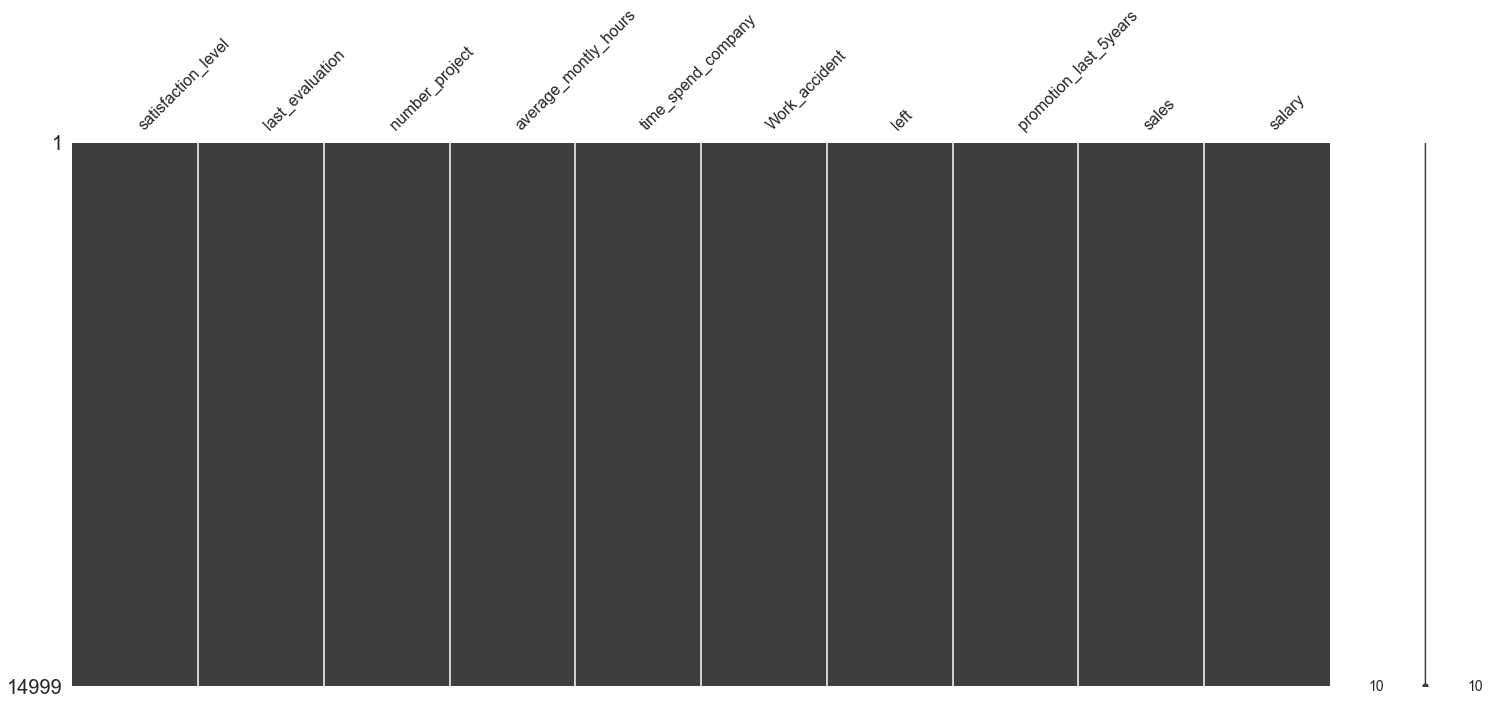

In [8]:
# Visualize missing values as a matrix
msno.matrix(df)

-----

# 8. Data manipulation

### 8.1 Rename columns

In [9]:
# Renaming columns with a better description
df = df.rename(columns={'satisfaction_level': 'satisfaction', 
                        'last_evaluation': 'evaluation',
                        'number_project': 'projectCount',
                        'average_montly_hours': 'averageMonthlyHours',
                        'time_spend_company': 'yearsAtCompany',
                        'Work_accident': 'workAccident',
                        'promotion_last_5years': 'promotion',
                        'sales' : 'department',
                        'left' : 'turnover'
                        })

### 8.2 Move target variable to the beginning of the dataset

In [10]:
# Moving the reponse variable "turnover" to the front of the table
front = df['turnover']
df.drop(labels=['turnover'], axis=1,inplace = True)
df.insert(0, 'turnover', front)
df.head()

,turnover,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,promotion,department,salary
0,1,0.38,0.53,2,157,3,0,0,sales,low
1,1,0.80,0.86,5,262,6,0,0,sales,medium
2,1,0.11,0.88,7,272,4,0,0,sales,medium
3,1,0.72,0.87,5,223,5,0,0,sales,low
4,1,0.37,0.52,2,159,3,0,0,sales,low


### 8.3 Check and remove duplicates

In [11]:
# Check for numbe of duplicates in the dataset
print(df.duplicated().sum())

3008


In [12]:
#Remove duplicates
df.drop_duplicates(inplace=True)

In [13]:
# Check for numbe of duplicates in the dataset
print(df.duplicated().sum())

0


-----

# 9. Exploratory Data Analysis

Let's explore the dataset and try to find some insights in the dataset. Some initial questions that can be explored 
- Turnover percentage across the firm
- Employee Attrition by years at company

### 9.1 Employee Attrition

In [14]:
# Turnover Percentage across the firm
'{:.2%}'.format(df['turnover'].sum()/df['turnover'].count())

'16.60%'

**Key Findings**


<blockquote>
    There is <b>16.60% Employee attrition</b> at the firm.
</blockquote>

-------

### 9.2 ->  Attrition rate is maximum for employees with 5 years of experience at the firm

### Key Findings
- We see that maximum attrition is when employees have spent 5 years with the firm. 
- Another interesting thing to note is that attrition rises gradually from 2 years duration and peaks at 5 years.
- Attrition falls sharply after has employee has spent more than 5 years with the firm

May be its the case that there is some `retention bonus paid at 5 years employment` and few employees
`leave immediately after taking the the bonus`.

Or it could also be the case that the retention bonus is `conditional`. 
Employees who don't get the `bonus leave` and those who get the bonus `continue to stay` with the firm.

### Key takeaways for the HR Department
- Why attrition is rising gradually for employees in 2-5 years range?
- 70% of the total attrition comes from employees in 4-5 years range
- Can we use some retention policies that we have for employees in >6 years range to lower retention in 4-5 years range?

In [15]:
#Calculate attrition rate by number of years spent at the firm
attritionRate = df.groupby('yearsAtCompany')['turnover'].sum()/df.groupby('yearsAtCompany')['turnover'].count()

In [16]:
#View attrition rate
attritionRate

yearsAtCompany
2     0.010653
3     0.168401
4     0.246883
5     0.453861
6     0.201107
7     0.000000
8     0.000000
10    0.000000
Name: turnover, dtype: float64

<AxesSubplot:xlabel='yearsAtCompany', ylabel='turnover'>

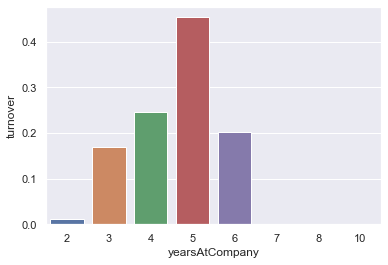

In [17]:
#Attrition rate by years spent at the firm
sns.barplot(x=attritionRate.index, y=attritionRate)

-------

### 9.3 ->  Employees with 3 to 5 years of experience reported lower satisfaction levels on average

### Key findings
- Average satisfaction levels dip for employees during 2 - 4 years stay at the firm
- Low satisfaction levels could be the reason for higher attrition rate in the employees with 2 - 5 years of stay bracket.
- Attrition distribution is tri-modal for employee satisfaction levels.
    - Certain Employees with `low` satisfaction
    - Majority of the Employees with `medium` satisfaction
    - Certain Employees with `high` satisfaction

### Key takeaways for the HR Department
- Why average satisfaction levels are low for employees in the 2-4 years range?
- Could low satisfaction levels be the reason for high attrition in the 2-4 years range?
- Why are employees with high satisfaction leaving the job? (May be better salary?)

In [18]:
#Average satisfaction levels by years spent at the firm
avgSatisfactionLevels = df.groupby('yearsAtCompany')['satisfaction'].mean()
avgSatisfactionLevels

yearsAtCompany
2     0.699165
3     0.648988
4     0.516090
5     0.583183
6     0.571107
7     0.635957
8     0.665062
10    0.655327
Name: satisfaction, dtype: float64

In [19]:
#Create a Dataframe to visualize the trend between Emp Satisfaction levels and attrition rate
tempDf = pd.DataFrame({"avgSatisfactionLevels": avgSatisfactionLevels, 
        "attritionRate": attritionRate})

<AxesSubplot:xlabel='yearsAtCompany'>

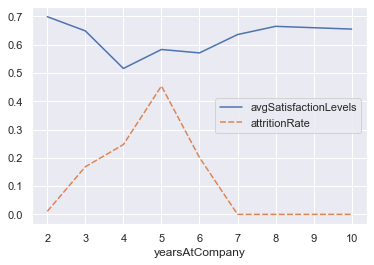

In [20]:
#View attrition rate and average satisfaction levels by years spent at the firm
sns.lineplot(data=tempDf)

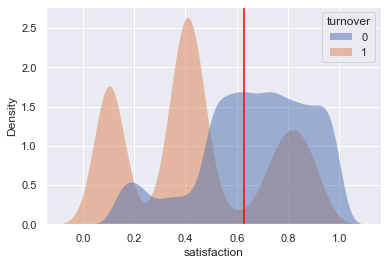

In [21]:
sns.kdeplot(data=df, x="satisfaction", hue="turnover", fill=True, common_norm=False,
   alpha=.5, linewidth=0)
plt.axvline(x=df.satisfaction.mean(),
            color='red')

------

### 9.4 ->  As expected, attrition rate is high for employees with low salaries

### Key findings
- Nearly 20% attrition rate in employees with low salaries
- Certain high salaries staff is also leaving the company

### Key takeaways for the HR Department
- Benchmark salaries of low salaries staff to check whether salary can be improved for certain staff
- Why are certain high salaried employees leaving the firm?

In [22]:
#Calculate attrition rate by salary
attritionRateBySalary = df.groupby('salary')['turnover'].sum()/df.groupby('salary')['turnover'].count()

In [23]:
attritionRateBySalary

salary
high      0.048485
low       0.204530
medium    0.146170
Name: turnover, dtype: float64

<AxesSubplot:xlabel='salary', ylabel='turnover'>

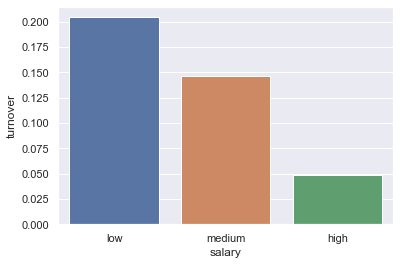

In [24]:
#Plot attrition rate by salary
sns.barplot(x=attritionRateBySalary.index, y=attritionRateBySalary, order=["low","medium","high"])

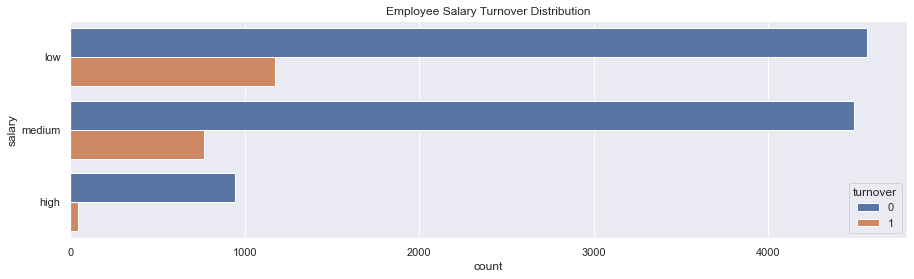

In [25]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y="salary", hue='turnover', data=df).set_title('Employee Salary Turnover Distribution');

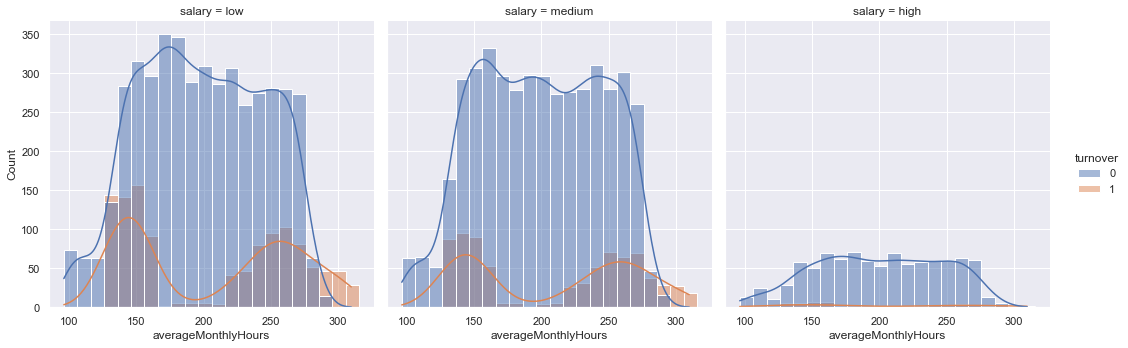

In [26]:
sns.displot(data=df, x="averageMonthlyHours", binwidth=10, kde=True, hue="turnover", col="salary")

-------

### 9.5 -> We note that there are 3 clusters of employees leaving the firm
- Top rated, Less satisfaction
- Top rated, Highly satisfaction
- Bottom rated, below average satisfaction

### Key takeaways for the HR Department
- Why were certain `Top rated` employees not satisfied with the firm?
    - Were they overworked?
    - Were they not satisfied with their job?
    - Was salary an issue?
    
- Why are `Top Rated` and `Highly satisfied employees` leaving the firm?
    - Are they looking for better opportunities?
    - Is salary or growth an issue for these set of employees?
    - Are they overworked?
    
- How can we help underperforming and unsatisfied employees?
    - Can we identify training gaps?
    - Is there some issue with our hiring policy, did we hire people with skills mismatch?

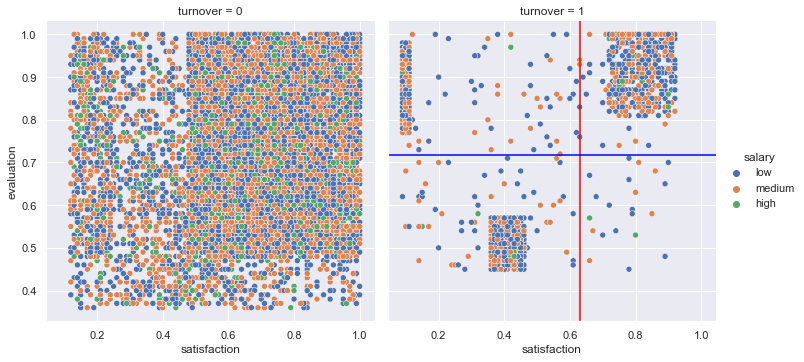

In [27]:
#Visualize scatter plot of satisfaction and evaluation 

#We create this scatterplot to understand how the combination of rating/evaluation effects employee turnover
sns.relplot(x="satisfaction", y="evaluation", col="turnover", hue="salary", data=df, kind="scatter")
plt.axvline(x=df.satisfaction.mean(),
            color='red')
plt.axhline(y=df.evaluation.mean(),
            color='blue')

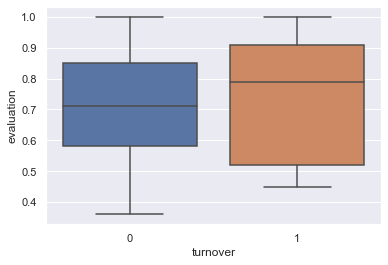

In [28]:
ax = sns.boxplot(x="turnover", y="evaluation", data=df)

-------

### 9.6 -> 54% of the employees who left the firm worked more than the average monthly hours (200 hours)
- Those employees worked hard and were highly satisfied with their job

### Key takeaways for the HR Department
- Why a group of hard working and highly satisfied employees left their job?

In [29]:
#Average working hours in the firm
df['averageMonthlyHours'].mean()

200.4735218080227

In [30]:
#Percentage of leaving employees who worked more than the average monthly hours
df.loc[(df["turnover"] == 1) & (df["averageMonthlyHours"] > 200), ["turnover"]].count()/df.loc[df["turnover"]==1,["turnover"]].count()

turnover    0.542943
dtype: float64

In [31]:
df.head()

,turnover,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,promotion,department,salary
0,1,0.38,0.53,2,157,3,0,0,sales,low
1,1,0.80,0.86,5,262,6,0,0,sales,medium
2,1,0.11,0.88,7,272,4,0,0,sales,medium
3,1,0.72,0.87,5,223,5,0,0,sales,low
4,1,0.37,0.52,2,159,3,0,0,sales,low


<function matplotlib.pyplot.show(close=None, block=None)>

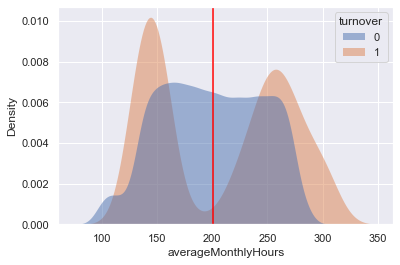

In [32]:
sns.kdeplot(data=df, x="averageMonthlyHours", hue="turnover", fill=True, common_norm=False,
   alpha=.5, linewidth=0)
plt.axvline(x=df.averageMonthlyHours.mean(),
            color='red')
plt.show

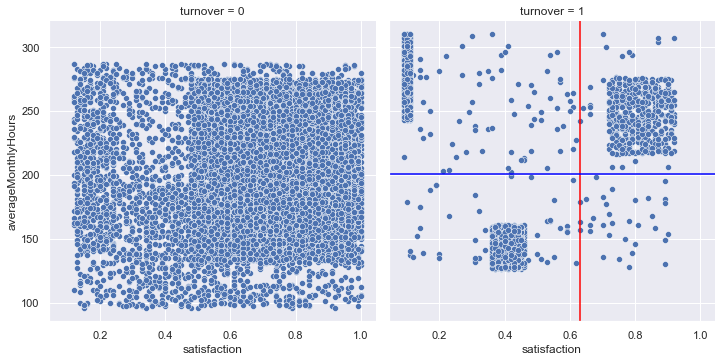

In [33]:
#Visualize scatter plot of satisfaction and evaluation 

#We create this scatterplot to understand how the combination of rating/evaluation effects employee turnover
sns.relplot(x="satisfaction", y="averageMonthlyHours", col="turnover", data=df, kind="scatter")
plt.axvline(x=df.satisfaction.mean(),
            color='red')
plt.axhline(y=df.averageMonthlyHours.mean(),
            color='blue')

------

### 9.7 -> Attrition by department

In [34]:
#Calculate average attrition by department
avgAttrition = (df.groupby(['department'])['turnover'].sum()/df.groupby(['department'])['turnover'].count()).sort_values(ascending=False)

In [35]:
avgAttrition

department
hr             0.188020
accounting     0.175523
technical      0.173797
support        0.171334
sales          0.169805
marketing      0.166419
IT             0.161885
product_mng    0.160350
RandD          0.122478
management     0.119266
Name: turnover, dtype: float64

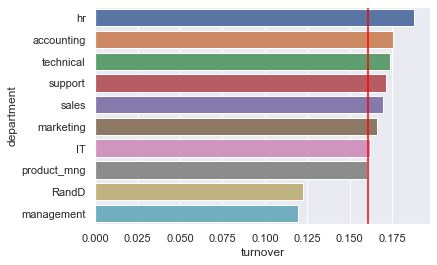

In [36]:
#Plot average attrition by department
sns.barplot(y=avgAttrition.index, x=avgAttrition)
plt.axvline(x=avgAttrition.mean(),
            color='red')

In [37]:
avgMonthlyHours = df.groupby(['department'])['averageMonthlyHours'].mean()
avgMonthlyHours

department
IT             200.638320
RandD          201.291066
accounting     200.877617
hr             199.371048
management     201.529817
marketing      199.487370
product_mng    198.893586
sales          200.242050
support        200.627128
technical      201.115419
Name: averageMonthlyHours, dtype: float64

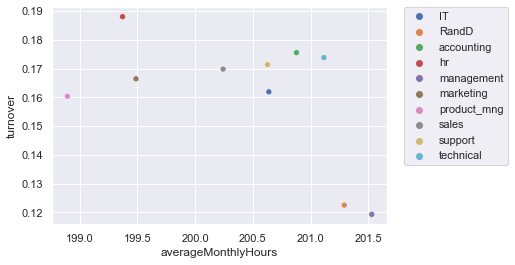

In [38]:
# Create scatterplot for avgMonthlyHours and avgAttrition
sns.scatterplot(x=avgMonthlyHours, y=avgAttrition, hue=avgMonthlyHours.index)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [39]:
from scipy.stats import pearsonr
#Calculate correlation coefficient between turnover and averageMonthlyHours
corr, _ = pearsonr(avgMonthlyHours, avgAttrition)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: -0.111


**From Pearson Correlation coefficient of -0.111, we note that there is not a 
significant correlation between working long hours and attrition rate**

In [40]:
temp = df.loc[df["turnover"] == 1,:].groupby('department')['averageMonthlyHours', 'satisfaction'].mean()

In [41]:
temp

,averageMonthlyHours,satisfaction
department,,
IT,209.537975,0.417089
RandD,212.741176,0.433529
accounting,209.541284,0.414679
hr,197.053097,0.422478
management,207.615385,0.435962
marketing,202.142857,0.454375
product_mng,205.972727,0.467909
sales,206.270909,0.450400
support,208.102564,0.451506


<AxesSubplot:xlabel='averageMonthlyHours', ylabel='satisfaction'>

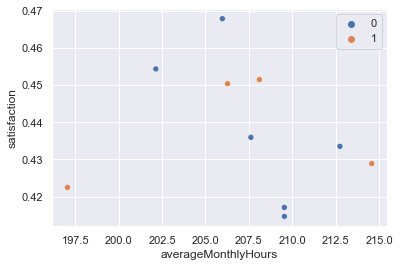

In [42]:
sns.scatterplot(x=temp["averageMonthlyHours"], y=temp["satisfaction"], hue=[0,0,0,1,0,0,0,1,1,1])

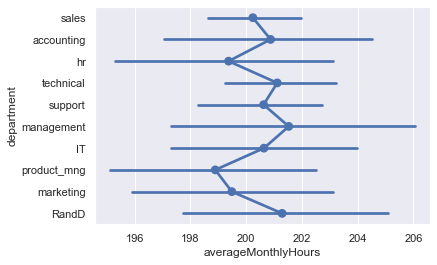

In [43]:
#Distribution of average working hours by department
ax = sns.pointplot(y="department", x="averageMonthlyHours", data=df)

**We note that there is no specific department which is overburdened and working very long hours**

--------

### 9.8 -> Attrition rate is high for employees in the under-worked and over-worked segment

### Key takeaways for the HR Department
- How can the workload be balance across employees?

<AxesSubplot:xlabel='projectCount', ylabel='Density'>

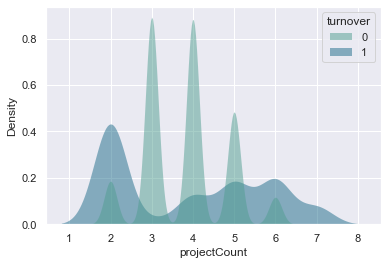

In [44]:
sns.kdeplot(
   data=df, x="projectCount", hue="turnover",
   fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=0,
)

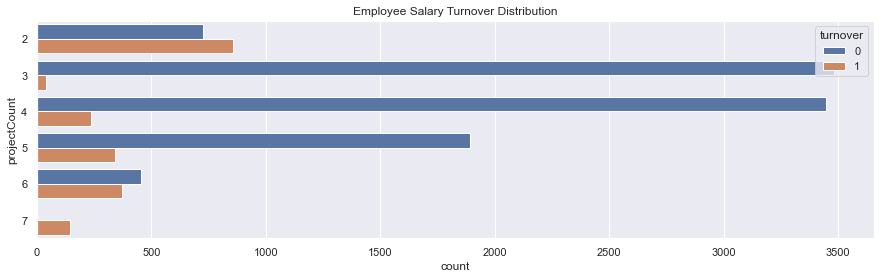

In [45]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y="projectCount", hue='turnover', data=df).set_title('Employee Salary Turnover Distribution');

---------

# 10. Data Pre-Processing (Dummy variables, Test-Train split and Feature Scaling)

### 10.1 Create train-test split

In [46]:
#Split the train and test data
train, test =  train_test_split(df,test_size=0.2, random_state=123, stratify=df['turnover'])
print(train.shape)
print(test.shape)

(9592, 10)
(2399, 10)


### 10.2 Custom Pre-Processing Transformers

In [47]:
#Get the list of categorical columns for Dummy Encoding 
dummyColList = ['department', 'salary']

In [48]:
#Get the list of numerical columns for Scaling
numCols = ['satisfaction', 'evaluation', 'projectCount', 'averageMonthlyHours', 'yearsAtCompany']

In [49]:
#Custom Transformer that transforms Categorical columns
class DummyEncoding( BaseEstimator, TransformerMixin):
    
    #Class Constructor
    def __init__(self, dummyColList):
        self.dummyColList = dummyColList
        
    #Return self nothing else to do here
    def fit( self, X, y = None  ):
        return self
    
    #Transformer method we wrote for this transformer 
    def transform(self, X , y = None ):
        
        #One-Hot Encoding of categorical columns
        #Get dummy variables
        for each_col in self.dummyColList:
            X[each_col] = pd.factorize(X[each_col])[0]
        
        return X

In [50]:
#Custom Transformer that scales Numerical columns
class CustomScaler( BaseEstimator, TransformerMixin):
    
    #Class Constructor
    def __init__(self, numCols):
        self.numCols = numCols
        self.scaler = MinMaxScaler()
        
    #Return self nothing else to do here
    def fit( self, X, y = None  ):
        self.scaler.fit(X[numCols])
        return self
    
    #Transformer method we wrote for this transformer 
    def transform(self, X , y = None ):
        
        X[numCols] = self.scaler.transform(X[numCols])
        
        return X

### 10.3 Pre-Processing pipeline

In [51]:
#Defining the steps in the categorical pipeline 
categorical_pipeline = Pipeline( steps = [('dummyEncodingTransformer', DummyEncoding(dummyColList))] )

In [52]:
#Defining the steps in the numerical pipeline     
numerical_pipeline = Pipeline( steps = [ ( 'min_max_scaler', CustomScaler(numCols)) ] )

In [53]:
#Combining numerical and categorical piepline into one full big pipeline horizontally 
#using FeatureUnion
preProcessingPipeline = Pipeline( steps = [ ( 'categorical_pipeline', categorical_pipeline ), 
                                                  
                                                  ( 'numerical_pipeline', numerical_pipeline ) ] )



In [54]:
preProcessingPipeline

Pipeline(steps=[('categorical_pipeline',
                 Pipeline(steps=[('dummyEncodingTransformer',
                                  DummyEncoding(dummyColList=['department',
                                                              'salary']))])),
                ('numerical_pipeline',
                 Pipeline(steps=[('min_max_scaler',
                                  CustomScaler(numCols=['satisfaction',
                                                        'evaluation',
                                                        'projectCount',
                                                        'averageMonthlyHours',
                                                        'yearsAtCompany']))]))])

In [55]:
#Fit_transform the pipeline on training data
train_transform = preProcessingPipeline.fit_transform(train)

In [56]:
#Transform the pipeline on test data
test_transform = preProcessingPipeline.transform(test)

### 10.4 Extract X and y

In [57]:
# Putting response variable to y
y_train = train_transform.pop('turnover')
X_train = train_transform

In [58]:
# Putting response variable to y
y_test = test_transform.pop('turnover')
X_test = test_transform

### 10.5 Class Imbalance treatment - SMOTE

In [59]:
sm = SMOTE(random_state=2)
X_train, y_train = sm.fit_resample(X_train, y_train.ravel())

-------

## 11. Model Inputs

### 11.1 Hyper Parameters for the model

In [60]:
#Hyper Parameters for different models 
paramsLogReg = {
                'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
                'C' : [100, 10, 1.0, 0.1, 0.01],
                'solver' : ['lbfgs','newton-cg','liblinear','sag','saga']
                }

paramsRidge = {"alpha": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
paramsSGD = {}
paramsNB = {'var_smoothing': np.logspace(0,-9, num=100)}
paramsKNN = {
            'n_neighbors' : range(1,21,2),
            'weights' : ['uniform','distance'],
            'metric' : ['minkowski','euclidean','manhattan']
            }

paramsDT = {
            'max_depth': [2, 3, 5, 10, 20],
            'min_samples_leaf': [5, 10, 20, 50, 100],
            'criterion': ["gini", "entropy"]
            }

paramsRF = {'n_estimators': [25, 50, 100, 150, 200], 
            'max_depth': [3, 5, 7, 9], 
            'max_features': ["auto", "sqrt", "log2"], 
            'random_state': [42]
           }

paramsBC = {
            "n_estimators": [10, 100, 1000]
            }

paramsGBC = {
            "n_estimators": [10, 100, 1000],
            "learning_rate": [0.001, 0.01, 0.1],
            "subsample": [0.5, 0.7, 1.0],
            "max_depth": [3, 7, 9]
            }



### 11.2 Models List

In [61]:
#List of models to evaluate
models = [{"modelName": "LogisticRegression", 
           "model": LogisticRegression(), 
           "modelAvgCVScore": 10, 
           "modelParams": paramsLogReg, 
           "cvResults": [], 
           "rfeStatus": True, 
           "rfeModels": [], 
           "rfeInputFeaturesCount": [], 
           "RFECVResults": []
          },
          
          {"modelName": "Ridge", 
           "model": RidgeClassifier(), 
           "modelAvgCVScore": 11, 
           "modelParams": paramsRidge, 
           "cvResults": [], 
           "rfeStatus": True, 
           "rfeModels": [], 
           "rfeInputFeaturesCount": [], 
           "RFECVResults": []},
          
          {"modelName": "SGD", 
           "model": SGDClassifier(), 
           "modelAvgCVScore": 9, 
           "modelParams": paramsSGD, 
           "cvResults": [], 
           "rfeStatus": True, 
           "rfeModels": [], 
           "rfeInputFeaturesCount": [], 
           "RFECVResults": []
          },
          
          {"modelName": "NaiveBayes", 
           "model": CategoricalNB(), 
           "modelAvgCVScore": 0, 
           "modelParams": paramsNB, 
           "cvResults": [], 
           "rfeStatus": False, 
           "rfeModels": [], 
           "rfeInputFeaturesCount": [], 
           "RFECVResults": []
          },
          
          {"modelName": "KNN", 
           "model": KNeighborsClassifier(), 
           "modelAvgCVScore": 0, 
           "modelParams": paramsKNN, 
           "cvResults": [], 
           "rfeStatus": False, 
           "rfeModels": [], 
           "rfeInputFeaturesCount": [], 
           "RFECVResults": []
          },
          
          {"modelName": "DecisionTree", 
           "model": DecisionTreeClassifier(), 
           "modelAvgCVScore": 0, 
           "modelParams": paramsDT, 
           "cvResults": [], 
           "rfeStatus": True, 
           "rfeModels": [], 
           "rfeInputFeaturesCount": [], 
           "RFECVResults": []
          },
        
          {"modelName": "RandomForest", 
           "model": RandomForestClassifier(n_estimators = 100), 
           "modelAvgCVScore": 0, 
           "modelParams": paramsRF, 
           "cvResults": [], 
           "rfeStatus": True, 
           "rfeModels": [], 
           "rfeInputFeaturesCount": [], 
           "RFECVResults": []
          },
          
          {"modelName": "BaggingClassifier", 
           "model": BaggingClassifier(), 
           "modelAvgCVScore": 0, 
           "modelParams": paramsBC, 
           "cvResults": [], 
           "rfeStatus": True, 
           "rfeModels": [], 
           "rfeInputFeaturesCount": [], 
           "RFECVResults": []
          },
          
          {"modelName": "BoostingClassifier", 
           "model": GradientBoostingClassifier(), 
           "modelAvgCVScore": 0, 
           "modelParams": paramsGBC, 
           "cvResults": [], 
           "rfeStatus": True, 
           "rfeModels": [], 
           "rfeInputFeaturesCount": [], 
           "RFECVResults": []
          }
          
         ]

### 11.3 RFE/RFECV Inputs

In [62]:
#Minimun number of features for RFE
min_features = 2

#Maximum number of features for RFE
max_features = 9

#Step size in RFECV
rfecvStep = 1

#Perform manual RFE
rfeStatus = False

#Perform Auto RFE
rfeCVStatus = True

### 11.4 Cross-Validation Inputs

In [63]:
#Scoring parameter
scoring = "roc_auc"

#Number of splits in K-Fold Cross Validation
n_splits = 5

#Random state
random_state = 23

#Shuffle in K-Fold cross validation
shuffle = True

# 12. Models Class

### 12.1 Models Class
The Models Class provides the following functionalities
- Initialize various Classification models along with respective hyper-parameters
- Run and compare model performance
- Select the best performing model
- Perform RFE on the best performing model
- Select the best features
- Run the final model

In [64]:
class Models:
    
    #Init Function
    def __init__(self, models, min_features, max_features, rfecvStep, scoring, n_splits, random_state, shuffle, rfeStatus, rfeCVStatus):
        
        self.models = models
        self.min_features = min_features
        self.max_features = max_features
        self.scoring = scoring
        self.n_splits = n_splits
        self.random_state = random_state
        self.shuffle = shuffle
        self.rfecvStep = rfecvStep
        self.rfeStatus = rfeStatus
        self.rfeCVStatus = rfeCVStatus
    
    #K-Fold Cross validation
    def crossValidation(self, model, X, y):
        #Instantiate KFold
        kfold = KFold(n_splits=self.n_splits, random_state=self.random_state, shuffle=self.shuffle)
        return cross_val_score(model, X, y, cv=kfold, scoring=self.scoring)
    
    #Function to runModels
    def runModels(self, X, y):
        
        print("Starting to execute and compare various models...")
        #Loop over each model and do K-Fold Cross validation to select the best model
        for each_model in self.models:
            print("Running {}".format(each_model["modelName"]))
            
            #List of CV results of each model
            each_model["cvResults"] = self.crossValidation(each_model["model"], X, y)
            
            #Average CV score
            each_model["modelAvgCVScore"] = each_model["cvResults"].mean()

        print("All models successfully executed")
    
    #Function to compare Model results        
    def compareModels(self, results, names):
        
        #Print results of various models
        for each_result, modelName in zip(results, names):
            print("Model Name: %s:" % (modelName))
            print("Model Average CV Score: %f" % (each_result.mean()))
            print("Model CV Std (%f)" % (each_result.std())) 
            print("CV_Results: ", (each_result))
            print("\n")
        
        # Box Plot of Model Results
        fig = plt.figure()
        fig.suptitle('Algorithm Comparison')
        ax = fig.add_subplot(111)
        plt.boxplot(results)
        ax.set_xticklabels(names)
        plt.xticks(rotation=45)
        plt.show()
        
    #Get shortlisted Model
    def getShortlistedModel(self):
        
        #Get shortlisted model based on highest average CV Score
        self.shortlistedModel = max(self.models, key=lambda x:x['modelAvgCVScore'])
        
        print("Shortlisted model is : ", self.shortlistedModel)
            
            
    #Function to run RFE models and return the CV results
    def runRFEModels(self, X, y):
        
        results = []
        
        print("These are the models: ", self.shortlistedModel["rfeModels"])
        
        if ((self.rfeStatus == True) and (self.shortlistedModel["rfeStatus"] == True)):
        
            #Loop over the rfe models for the shortlisted model
            for each_model in self.shortlistedModel["rfeModels"]:
            
                #CV results of each model
                cvResults = self.crossValidation(each_model, X, y)
                print("Average score is : ", cvResults.mean())
            
                results.append(cvResults)
            
        return results
            
            
    #Get the list of RFE Models
    def getRfeModels(self):

        #Perform RFE on the model
        for i in range(self.min_features, self.max_features):
            rfe = RFE(estimator=self.shortlistedModel["model"], n_features_to_select=i)
            self.shortlistedModel["rfeModels"].append(Pipeline(steps=[('selection',rfe),('model',self.shortlistedModel["model"])]))
            self.shortlistedModel["rfeInputFeaturesCount"].append(i)

                    
    #Set optimial number of features based on RFE Model
    def getOptimalNumFeatures(self):
#         self.shortlistedModel[]

        #It is an array of arrays with each nested array containing CV results
        results = modelObj.shortlistedModel["RFECVResults"]
        meanResults = [x.mean() for x in results]
        maxpos = meanResults.index(max(meanResults)) 

        self.optimalFeatures =  list(range(self.min_features, self.max_features))[maxpos]

    
    #Run shortlisted RFE Model with optimal number of features to actually get feature names
    def getBestFeatures(self, X, y):
        
        
        rfe = RFE(estimator=self.shortlistedModel["model"], n_features_to_select=self.optimalFeatures)
        self.pipe = Pipeline(steps=[('selection',rfe), ('model', self.shortlistedModel["model"])])
        self.pipe.fit(X, y)

        # summarize all features
        print("Summarizing the results of RFE")
        for each_col, col_num in zip(X.columns, list(range(X.shape[1]))):
            print('ColumnName: %s | Selected %s | Rank: %.3f' % (each_col, rfe.support_[col_num], rfe.ranking_[col_num]))


        print("\n")
        print("List of selected columns")
        print(list(zip(X.columns,rfe.support_,rfe.ranking_)))

        #Visualize the selected columns
        print("\n")
        print("Visualize selected columns")
        print(X.columns[rfe.support_])

        return X.columns[rfe.support_]
        
    
    #Run RFECV Model to find the names of optimal features
    def getBestFeaturesCV(self, X, y):

        rfecv = RFECV(estimator=self.shortlistedModel["model"], step=self.rfecvStep, cv=self.n_splits)

        self.pipe = Pipeline(steps=[('selection',rfecv), ('model', self.shortlistedModel["model"])])
        self.pipe.fit(X, y)

        # summarize all features
        print("Summarizing the results of RFE")
        for each_col, col_num in zip(X.columns, list(range(X.shape[1]))):
            print('ColumnName: %s | Selected %s | Rank: %.3f' % (each_col, rfecv.support_[col_num], rfecv.ranking_[col_num]))


        print("\n")
        print("List of selected columns")
        print("this is rfecv support: ", rfecv.support_)
        print(list(zip(X.columns,rfecv.support_,rfecv.ranking_)))

        #Visualize the selected columns
        print("\n")
        print("Visualize selected columns")
        print(X.columns[rfecv.support_])

        return X.columns[rfecv.support_]
    
        
    def getParams(self, modelName):
        
        for each_param in self.params:
            
            if each_param["modelName"] == modelName:
                return each_param["modelParams"]
            
            else:
                return 0
               
    def hyperParameterOptimization(self):
        # Instantiate the grid search model
        grid_search = RandomizedSearchCV(estimator=self.shortlistedModel["model"], 
                           param_distributions=self.shortlistedModel["modelParams"], 
                           cv=self.n_splits, n_jobs=-1, verbose=1, scoring = self.scoring)
        
        grid_search.fit(X_train, y_train)
        
        return grid_search.best_estimator_
    
    def runFinalModel(self):
        pass
    
    def evaluateModel(self):
        pass

### 12.2 Instantiate Models class

In [65]:
#Instantiate Models class
modelObj = Models(models, min_features, max_features, rfecvStep, scoring, n_splits, random_state, shuffle, rfeStatus, rfeCVStatus)

### 12.3 Run multiple models

In [66]:
#Run the models and print score
modelObj.runModels(X_train, y_train)

Starting to execute and compare various models...
Running LogisticRegression
Running Ridge
Running SGD
Running NaiveBayes
Running KNN
Running DecisionTree
Running RandomForest
Running BaggingClassifier
Running BoostingClassifier
All models successfully executed


### 12.4 Compare model performance

In [67]:
#Store CV results and names of various models
results = [x["cvResults"] for x in modelObj.models]
names = [x["modelName"] for x in modelObj.models]

Model Name: LogisticRegression:
Model Average CV Score: 0.847714
Model CV Std (0.008173)
CV_Results:  [0.83851839 0.85713259 0.8419671  0.84297674 0.85797382]


Model Name: Ridge:
Model Average CV Score: 0.843808
Model CV Std (0.008291)
CV_Results:  [0.83474129 0.85337165 0.83861853 0.83802702 0.85427958]


Model Name: SGD:
Model Average CV Score: 0.844975
Model CV Std (0.006630)
CV_Results:  [0.83607248 0.84806978 0.84140413 0.84357322 0.85575556]


Model Name: NaiveBayes:
Model Average CV Score: 0.670486
Model CV Std (0.009886)
CV_Results:  [0.6680633  0.65515921 0.67940186 0.68294468 0.66686015]


Model Name: KNN:
Model Average CV Score: 0.982449
Model CV Std (0.002418)
CV_Results:  [0.97978159 0.98581934 0.98430302 0.97974654 0.98259515]


Model Name: DecisionTree:
Model Average CV Score: 0.975652
Model CV Std (0.003313)
CV_Results:  [0.97288889 0.98067491 0.97126113 0.97719468 0.97624174]


Model Name: RandomForest:
Model Average CV Score: 0.997512
Model CV Std (0.001004)
CV_Resul

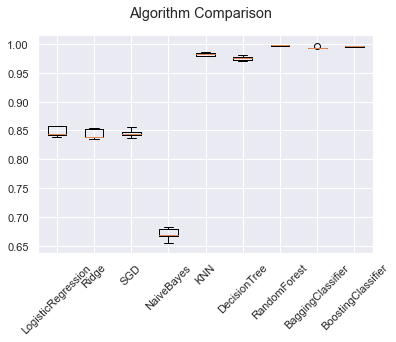

In [68]:
#Plot the results
modelObj.compareModels(results, names)

# 13. Shortlist top performing model

In [69]:
#Set the shortlisted Model
modelObj.getShortlistedModel()

Shortlisted model is :  {'modelName': 'RandomForest', 'model': RandomForestClassifier(), 'modelAvgCVScore': 0.9975122067734897, 'modelParams': {'n_estimators': [25, 50, 100, 150, 200], 'max_depth': [3, 5, 7, 9], 'max_features': ['auto', 'sqrt', 'log2'], 'random_state': [42]}, 'cvResults': array([0.99639346, 0.99829711, 0.99618378, 0.99846658, 0.99822011]), 'rfeStatus': True, 'rfeModels': [], 'rfeInputFeaturesCount': [], 'RFECVResults': []}


# 14. Recursive Feature Elimination

In [70]:
#Get the List of RFE Models based on number of features and the shortlisted model

if ((modelObj.rfeStatus == True) and (modelObj.shortlistedModel["rfeStatus"] == True)):
   
    #Get RFE Models
    modelObj.getRfeModels()
    
    #Run RFE Models and get rfeCVResults
    modelObj.shortlistedModel["RFECVResults"] = modelObj.runRFEModels(X_train, y_train)
    
    #Compare RFE Model results
    modelObj.compareModels(modelObj.shortlistedModel["RFECVResults"], list(range(modelObj.min_features, modelObj.max_features)))
    
    #Select the best performing RFE Model and number of features
    modelObj.getOptimalNumFeatures()
    
    #Get the names of selected columns by RFE
    selectColumns = modelObj.getBestFeatures(X_train, y_train)

In [71]:
#View the shortlisted Model
modelObj.shortlistedModel

{'modelName': 'RandomForest',
 'model': RandomForestClassifier(),
 'modelAvgCVScore': 0.9975122067734897,
 'modelParams': {'n_estimators': [25, 50, 100, 150, 200],
  'max_depth': [3, 5, 7, 9],
  'max_features': ['auto', 'sqrt', 'log2'],
  'random_state': [42]},
 'cvResults': array([0.99639346, 0.99829711, 0.99618378, 0.99846658, 0.99822011]),
 'rfeStatus': True,
 'rfeModels': [],
 'rfeInputFeaturesCount': [],
 'RFECVResults': []}

# 15. RFECV

In [72]:
#Check if rfeCVStatus == True
if ((modelObj.rfeCVStatus == True) and (modelObj.shortlistedModel["rfeStatus"] == True)):
    selectColumns = modelObj.getBestFeaturesCV(X_train, y_train)

Summarizing the results of RFE
ColumnName: satisfaction | Selected True | Rank: 1.000
ColumnName: evaluation | Selected True | Rank: 1.000
ColumnName: projectCount | Selected True | Rank: 1.000
ColumnName: averageMonthlyHours | Selected True | Rank: 1.000
ColumnName: yearsAtCompany | Selected True | Rank: 1.000
ColumnName: workAccident | Selected True | Rank: 1.000
ColumnName: promotion | Selected False | Rank: 3.000
ColumnName: department | Selected True | Rank: 1.000
ColumnName: salary | Selected False | Rank: 2.000


List of selected columns
this is rfecv support:  [ True  True  True  True  True  True False  True False]
[('satisfaction', True, 1), ('evaluation', True, 1), ('projectCount', True, 1), ('averageMonthlyHours', True, 1), ('yearsAtCompany', True, 1), ('workAccident', True, 1), ('promotion', False, 3), ('department', True, 1), ('salary', False, 2)]


Visualize selected columns
Index(['satisfaction', 'evaluation', 'projectCount', 'averageMonthlyHours',
       'yearsAtCompany

# 16. Feature Selection

In [73]:
#If we are doing Recursive Feature Elimination
if (((modelObj.rfeStatus == True) or (modelObj.rfeCVStatus == True)) and (modelObj.shortlistedModel["rfeStatus"] == True)):
    X_train_rfe = X_train[selectColumns]
    X_test_rfe = X_test[selectColumns]
    
else:
    X_train_rfe = X_train
    X_test_rfe = X_test

In [74]:
X_train_rfe

,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,department
0,0.384615,0.312500,0.200000,0.126168,0.125000,0,0
1,0.978022,0.125000,0.400000,0.271028,0.500000,1,1
2,0.736264,0.984375,0.200000,0.172897,0.250000,0,1
3,0.417582,0.296875,0.000000,0.280374,0.000000,0,2
4,0.824176,0.500000,0.400000,0.257009,0.000000,0,3
...,...,...,...,...,...,...,...
15993,0.886227,0.767497,0.600000,0.766635,0.375000,0,0
15994,0.146343,0.774105,0.676828,0.759517,0.326982,0,4
15995,0.786046,0.944841,0.400000,0.805244,0.375000,0,1
15996,0.347921,0.302174,0.000000,0.261519,0.125000,0,5


# 17. Model Tuning - Hyperparameter optimization

In [75]:
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [76]:
modelObj.shortlistedModel["model"]

RandomForestClassifier()

In [77]:
finalModel = modelObj.hyperParameterOptimization()

Fitting 5 folds for each of 10 candidates, totalling 50 fits


# 18. Final Model

In [78]:
#Visualize the Final Model
finalModel

RandomForestClassifier(max_depth=9, max_features='log2', n_estimators=150,
                       random_state=42)

In [79]:
#Fit the final Model
finalModel.fit(X_train_rfe, y_train)

RandomForestClassifier(max_depth=9, max_features='log2', n_estimators=150,
                       random_state=42)

In [80]:
#Predictions on Final Model
y_test_pred = finalModel.predict(X_test_rfe)

# 19. Evaluate Final Model

In [81]:
print(accuracy_score(y_test, y_test_pred))
confusion_matrix(y_test, y_test_pred)

0.9795748228428511


array([[1988,   13],
       [  36,  362]])

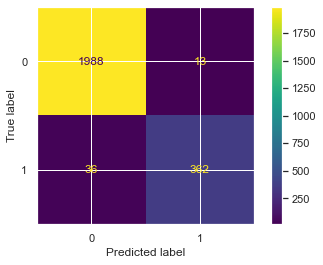

In [82]:
cm = confusion_matrix(y_test, y_test_pred, labels=finalModel.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=finalModel.classes_)
disp.plot()

plt.show()

## End of notebook